In [1]:
import pymongo as pmg
import pandas as pd
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from matplotlib.lines import TICKLEFT, TICKRIGHT, Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.dates as mdate
from datetime import time
from KRData.HKData import HKFuture
import talib as tb
import configparser
from kline import Kline

conf_parser = configparser.ConfigParser()
conf_parser.read( 'conf.ini')
mg_host = conf_parser.get('MGDB', 'host')
mg_user = conf_parser.get('MGDB', 'user')
mg_password = conf_parser.get('MGDB', 'password')
hf=HKFuture(pwd=mg_password,host=mg_host,user=mg_user)
# hf=HKFuture()
begin='2011-01-01'
dt1=dt.datetime.now()
_fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol','trade_date']
df=hf.get_bars('HSI1201',_fields)
df.head()

OK


,datetime,code,open,high,low,close,trade_date
datetime,,,,,,,
2011-11-30 09:15:00,2011-11-30 09:15:00,HSI1201,18157.0,18157.0,18113.0,18113.0,2011-11-30
2011-11-30 09:17:00,2011-11-30 09:17:00,HSI1201,18131.0,18131.0,18130.0,18130.0,2011-11-30
2011-11-30 09:19:00,2011-11-30 09:19:00,HSI1201,18140.0,18140.0,18140.0,18140.0,2011-11-30
2011-11-30 09:21:00,2011-11-30 09:21:00,HSI1201,18127.0,18127.0,18115.0,18115.0,2011-11-30
2011-11-30 09:28:00,2011-11-30 09:28:00,HSI1201,18107.0,18107.0,18107.0,18107.0,2011-11-30


In [66]:
class BT_Calc():
       
#初始化-----------------------------------------------------------------------
    def __init__(self,hf:HKFuture,index='HSI',**arg):
        self.hf=hf
        self._DateList=hf.get_main_contract_trade_dates(index)
        self.Test_Trade=True
        self.std_base=2.5
        self.cls()
    
#清理-----------------------------------------------------------------------------
    def cls(self):
        self._para={}
        self._res={}
        self._res['macd']=[]
        self._res['ma60']=[]
        self._res['std']=[]
        self._res['trade']=[]
        self.macd_no=0
        self.ma60_no=0
        self.std_no=0
        self.std_pre_macd=0
        self.std_pre_ma60=0
#当前指数全部品种进行测试---------------------------------------------------------------------
    def contract_all(self,isTrade=True):
        self.cls()
        for k in self._DateList.keys():
            # print(k)
            self.contract(k,isTrade)
            
#按单月合约进行测试-----------------------------------------------------------------------------
    def contract(self,prod,isTrade=True):
        self.contract_init(prod)
        self._para['prod']=prod
        dt1=dt.time(9,15)
        dt2=dt.time(16,30)
        date_list=self._DateList[prod]
        self.dl=date_list
        for dd in date_list:
            self._para['date']=dd
            date1=str(dd.date())
            df=self._para['df_prod'][self._para['df_prod']['trade_date']==date1]
            if len(df)<2:
                break
            day_only=df.datetime.apply(lambda x:x.time()>=dt1 and x.time()<=dt2 )
            self._para['df1']=df[day_only]
            if len(df[day_only])<2:
                break
            self.day_loop()
    
#单月品种测试前的初如化---------------------------------------------------------------------------
    def contract_init(self,prod):
        _fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol','trade_date']
        df1=self.hf.get_bars(prod,_fields)
        df1['macd'],df1['diff'],df1['dea']=tb.MACD(df1.close.values,fastperiod=12,slowperiod=26,signalperiod=9)
        df1['ma30']=tb.EMA(df1.close.values,timeperiod=30)
        df1['ma60']=tb.EMA(df1.close.values,timeperiod=60)
        df1['bias']=(df1['close']-df1['ma60'])/df1['ma60']*100
        df1['chg']=df1['close']-df1['open']
        df1['std60']=tb.STDDEV(df1['chg'].values,timeperiod=60)
        df1['std1']=df1['chg']/df1['std60']
        self._para['df_prod']=df1

#每个交易日每条记录循环部分(只计算)-----------------------------------------------------------------------------------
    def day_loop(self):
        self.day_calc_init()
        df=self._para['df1']
        self._para['day_no']=0
        for i,row in df.iterrows():
            self._para['row']=row
            self.day_calc_main()
            self._para['day_no']+=1
        self.day_calc_end()

#计算前准备----------------------------------------------------------------------------------
    def day_calc_init(self):
        self.ma60_init()
        self.macd_init()
        
#计算主体部分----------------------------------------------------------------------------------
    def day_calc_main(self):
        self.ma60_calc()
        self.macd_calc()
        if abs(self._para['row']['std1'])>=self.std_base:
            self.std_calc()
        
#每天结束部分---------------------------------------------------------------------------------
    def day_calc_end(self):
        self.ma60_end()
        self.macd_end()


#初始化MA60----------------------------------------------------------------------------------
    def ma60_init(self):
        row1=self._para['df1'].iloc[0]

        self._para['ma60']={}
        self._para['ma60_no_over']=0
        self._para['ma60_no_under']=0
        self._para['ma60']['no']=0
        self._para['ma60']['cnt']=1
        self._para['ma60']['begin']=row1['close']
        self._para['ma60']['state']='over' if row1['close']>=row1['ma60'] else 'under'
        
#计算MA60------------------------------------------------------------------------------------------
    def ma60_calc(self):
        ma60=self._para['ma60']
        row=self._para['row']
        state=0
        if row['close']>=row['ma60'] and ma60['state'] =='under':
            state=1
            self._para['ma60_no_under']+=1
        elif row['close']<row['ma60'] and ma60['state']=='over':
            self._para['ma60_no_over']+=1
            state=2
        else:
            state=0
            ma60['cnt']+=1
        
        if state>0:
            ma60['prod']=self._para['prod']
            ma60['date']=self._para['date']
            ma60['end']=row['close']
            ma60['end_idx']=self._para['day_no']
            ma60['diff']=ma60['end']-ma60['begin'] if state==2 else ma60['begin']-ma60['end']
            ma60['idx']=self.ma60_no
            self._res['ma60'].append(ma60)
            self.ma60_no+=1
#             print(ma60)
            ma60={}
            ma60['no']=self._para['ma60_no_over'] if state==2 else self._para['ma60_no_under']
            ma60['state']='over' if state==1 else 'under'
            ma60['begin']=row['close']
            ma60['cnt']=1
            ma60['begin_idx']=self._para['day_no']
            self._para['macd_no_red']=0
            self._para['macd_no_green']=0
        self._para['ma60']=ma60

#每天MA60结束------------------------------------------------------------------------------------------       
    def ma60_end(self):
        ma60=self._para['ma60']
        row=self._para['row'] 
        if ma60['cnt']<2:
            return
        ma60['prod']=self._para['prod']
        ma60['date']=self._para['date']
        ma60['end']=row['open']
        ma60['end_idx']=self._para['day_no']
        ma60['diff']=ma60['end']-ma60['begin'] if ma60['state']=='over' else ma60['begin']-ma60['end']
        ma60['idx']=self.ma60_no
        self._res['ma60'].append(ma60)
        self.ma60_no+=1
        pass

#初绍化MACD----------------------------------------------------------------------------------
    def macd_init(self):
        row1=self._para['df1'].iloc[0]
        self._para['macd']={}
        self._para['macd']['begin']=row1['close']
        self._para['macd']['state']='red' if row1['macd']>=0 else 'green'
        self._para['macd']['ma60_state']=self._para['ma60']['state']
        self._para['macd']['ma60_no']=0
        self._para['macd']['no']=0
        self._para['macd']['begin_idx']=0
        self._para['macd_no_red']=0
        self._para['macd_no_green']=0
        self._para['macd']['cnt']=1
        self._para['macd']['std_up']=0
        self._para['macd']['std_dn']=0
        self._para['macd']['day_no']=0
        self._para['macd']['std_up_list']=[]
        self._para['macd']['std_dn_list']=[]
        self._para['macd']['max_close']=row1['close']
        self._para['macd']['min_close']=row1['close']
        self._para['macd']['max_up']=0
        self._para['macd']['max_dn']=0
        self._para['macd']['max_idx']=1
        self._para['macd']['min_idx']=1
        self._para['macd']['date']=self._para['date']
        self._para['macd_day_no']=0                 
        

#计算MACD---------------------------------------------------------------------
    def macd_calc(self):
        macd=self._para['macd']
        row=self._para['row']
        state=0
        if row['macd']>0 and macd['state']=='green':
            state=1
            self._para['macd_no_red']+=1
        elif row['macd']<0 and macd['state']=='red':
            state=2
            self._para['macd_no_green']+=1
        else:
            macd['cnt']+=1
            self.Macd_State='keep'
            if row['close']>macd['max_close']:
                macd['max_close']=row['close']
                macd['max_idx']=macd['cnt']
            if row['close']<macd['min_close']:
                macd['min_close']=row['close']
                macd['min_idx']=macd['cnt']
            
            max_up=row['close']-macd['min_close']
            max_dn=macd['max_close']-row['close']
            
            if max_up>macd['max_up']:
                macd['max_up']=max_up
                macd['maxup_idx1']=macd['min_idx']
                macd['maxup_idx2']=macd['cnt']
            
            if max_dn>macd['max_dn']:
                macd['max_dn']=max_dn
                macd['maxdn_idx1']=macd['max_idx']
                macd['maxdn_idx2']=macd['cnt']
            
            self.Macd_End={}
            
        if state>0:
            macd['end']=row['close']
            macd['end_idx']=self._para['day_no']
            macd['end_no']=self._para['macd_no_red'] if state==2 else self._para['macd_no_green']
            macd['diff']=macd['end']-macd['begin'] if state==2 else macd['begin']-macd['end']
            macd['ma60_state_end']=self._para['ma60']['state']
            macd['idx']=self.macd_no
            self._res['macd'].append(macd)
            self.macd_no+=1
            self.Macd_End=macd
            self.Macd_State=macd['state']
            macd={}
            macd['std_up'],macd['std_dn']=0,0
            macd['std_up_list']=[]
            macd['std_dn_list']=[]

            
        if row['std1']>=1.5:
            macd['std_up']+=1
            std={}
            std['diff']=row['close']-row['open']
            std['idx']=self._para['day_no']
            macd['std_up_list'].append(std)
        elif row['std1']<=-1.5:
            macd['std_dn']+=1
            std={}
            std['diff']=row['close']-row['open']
            std['idx']=self._para['day_no']
            macd['std_dn_list'].append(std)
            
        if state>0:
            macd['prod']=self._para['prod']
            macd['date']=self._para['date']
            self._para['macd_day_no']+=1
            macd['day_no']=self._para['macd_day_no']
            macd['ma60_state']=self._para['ma60']['state']
            macd['ma60_no']=self._para['ma60']['no']
            macd['no']=self._para['macd_no_red'] if state==1 else self._para['macd_no_green']
            macd['cnt']=1
            macd['state']='red' if state==1 else 'green'
            macd['begin']=row['close']
            macd['begin_idx']=self._para['day_no']
            macd['max_close']=row['close']
            macd['min_close']=row['close']
            macd['max_idx']=1
            macd['min_idx']=1
            macd['max_up']=0
            macd['max_dn']=0
            
        self._para['macd']=macd

#每天MACD结束----------------------------------------------------------------------------------  
    def macd_end(self):
        macd=self._para['macd']
        if macd['cnt']<2:
            return
        row=self._para['row']
        macd['end']=row['close']
        macd['end_idx']=self._para['day_no']
        macd['end_no']=self._para['macd_no_red'] if macd['state']=='red' else self._para['macd_no_green']
        macd['diff']=macd['end']-macd['begin'] if macd['state']=='red' else macd['begin']-macd['end']
        macd['ma60_state_end']=self._para['ma60']['state']
        macd['idx']=self.macd_no
        self._res['macd'].append(macd)
        self.macd_no+=1
#std标准差异动的计算----------------------------------------------------------------------------
    def std_calc(self):
        std_dict={}
        row=self._para['row']
        std_dict['idx']=self.std_no
        std_dict['std']=row['std1']
        std_dict['state']=1 if row['std1']>0 else 2
        std_dict['day_no']=self._para['day_no']
        std_dict['date']=self._para['date']
        std_dict['chg']=row['chg']
        std_dict['close']=row['close']
        std_dict['macd_idx']=self.macd_no
        std_dict['macd_cnt']=self._para['macd']['cnt']
        std_dict['macd_state']=self._para['macd']['state']
        if self.macd_no==self.std_pre_macd:
            std_dict['macd_no']=self.std_no-self.std_pre_macd_idx
        else:
            std_dict['macd_no']=0
            self.std_pre_macd_idx=self.std_no
        self.std_pre_macd=self.macd_no
        std_dict['ma60_idx']=self.ma60_no
        std_dict['ma60_cnt']=self._para['ma60']['cnt']
        std_dict['ma60_state']=self._para['ma60']['state']
        if self.ma60_no==self.std_pre_ma60:
            std_dict['ma60_no']=self.std_no-self.std_pre_ma60_idx
        else:
            std_dict['ma60_no']=0
            self.std_pre_ma60_idx=self.std_no
        self.std_pre_ma60=self.ma60_no
        self._res['std'].append(std_dict)
        self.std_no+=1
print("OK")

OK


In [68]:
import time
t1=time.time()
bt=BT_Calc(hf)
bt.std_base=3
bt.contract_all()
t2=time.time()
print(t2-t1)
macd=bt._res['macd']
macd=pd.DataFrame(macd)
print(macd.columns)
macd.head()

199.8871431350708
Index(['begin', 'begin_idx', 'cnt', 'date', 'day_no', 'diff', 'end', 'end_idx',
       'end_no', 'idx', 'ma60_no', 'ma60_state', 'ma60_state_end', 'max_close',
       'max_dn', 'max_idx', 'max_up', 'maxdn_idx1', 'maxdn_idx2', 'maxup_idx1',
       'maxup_idx2', 'min_close', 'min_idx', 'no', 'prod', 'state', 'std_dn',
       'std_dn_list', 'std_up', 'std_up_list'],
      dtype='object')


,begin,begin_idx,cnt,date,day_no,diff,end,end_idx,end_no,idx,...,maxup_idx2,min_close,min_idx,no,prod,state,std_dn,std_dn_list,std_up,std_up_list
0,23143.0,0,36,2011-01-03,0,18.0,23125.0,35,0,0,...,35.0,23076.0,26,0,NaN,green,0,[],0,[]
1,23125.0,35,81,2011-01-03,1,253.0,23378.0,116,0,1,...,51.0,23116.0,12,1,HSI1101,red,0,[],3,"[{'diff': 122.0, 'idx': 59}, {'diff': 41.0, 'i..."
2,23378.0,116,3,2011-01-03,2,-24.0,23402.0,119,1,2,...,3.0,23378.0,1,1,HSI1101,green,0,[],0,[]
3,23402.0,119,28,2011-01-03,3,-12.0,23390.0,147,1,3,...,10.0,23392.0,3,1,HSI1101,red,0,[],0,[]
4,23390.0,147,19,2011-01-03,4,-32.0,23422.0,166,0,4,...,19.0,23370.0,12,2,HSI1101,green,0,[],1,"[{'diff': 16.0, 'idx': 165}]"


In [69]:
ma60=bt._res['ma60']
ma60=pd.DataFrame(ma60)
print(ma60.columns)
ma60.head()

std=pd.DataFrame( bt._res['std'])
std.head()
ma60.head()

Index(['begin', 'begin_idx', 'cnt', 'date', 'diff', 'end', 'end_idx', 'idx',
       'no', 'prod', 'state'],
      dtype='object')


,begin,begin_idx,cnt,date,diff,end,end_idx,idx,no,prod,state
0,23143.0,NaN,60,2011-01-03,-146.0,23289.0,59,0,0,HSI1101,under
1,23289.0,59.0,91,2011-01-03,92.0,23381.0,150,1,1,HSI1101,over
2,23381.0,150.0,1,2011-01-03,-7.0,23388.0,151,2,1,HSI1101,under
3,23388.0,151.0,5,2011-01-03,-10.0,23378.0,156,3,2,HSI1101,over
4,23378.0,156.0,8,2011-01-03,-7.0,23385.0,164,4,2,HSI1101,under


In [70]:
cols=['idx','diff','end','prod','end_idx']
ma60a=ma60[cols]
std1=pd.merge(std,ma60a,left_on='ma60_idx',right_on='idx',how='left')
std1['end_chg']=std1.apply(lambda x:x.end-x.close if x['std']>0 else x.close-x.end,axis=1)
calc={
'end_chg':['mean','count',sum,max,min]   
}
# std1[abs(std1['std'])>2.5].groupby('macd_no').agg(calc)
std1.groupby(['ma60_no','state','ma60_state']).agg(calc)
# std1.head()

end_chg                              
                                mean count      sum     max    min
ma60_no state ma60_state                                          
0       1     over          0.978422  2966   2902.0   688.0 -502.0
              under         9.200514   389   3579.0   203.0 -356.0
        2     over          2.879418   481   1385.0   196.0 -442.0
              under         3.538020  2959  10469.0  1087.0 -335.0
1       1     over          0.164062   896    147.0   551.0 -246.0
              under        -0.130719   306    -40.0   272.0 -310.0
        2     over          2.840580   276    784.0   162.0 -410.0
              under         8.327081   853   7103.0   581.0 -241.0
2       1     over          2.765172   379   1048.0   520.0 -185.0
              under         3.617021   141    510.0   134.0 -217.0
        2     over          7.528000   125    941.0   133.0 -260.0
              under        10.674300   393   4195.0   372.0 -317.0
3       1     over          9.194805   154   1416.0   382.0 -196.0
              under       -15.603448    58   -905.0   132.0 -432.0
        2     over         -7.432836    67   -498.0   134.0 -256.0
              under       -10.554945   182  -1921.0   297.0 -357.0
4       1     over         16.031746    63   1010.0   237.0 -208.0
              under        23.363636    33    771.0   133.0 -153.0
        2     over        -20.142857    21   -423.0   157.0 -400.0
              under       -19.438356    73  -1419.0   254.0 -594.0
5       1     over         -8.531250    32   -273.0   370.0 -190.0
              under        17.250000    16    276.0    75.0 -136.0
        2     over         48.666667     3    146.0   187.0  -43.0
              under       -10.750000    20   -215.0   212.0 -161.0
6       1     over         50.000000     8    400.0   318.0  -66.0
              under         4.500000     2      9.0    44.0  -35.0
        2     over         16.000000     1     16.0    16.0   16.0
              under        33.333333     6    200.0   137.0  -42.0
7       1     over        -28.800000     5   -144.0   249.0 -203.0
        2     under       -79.333333     3   -238.0     0.0 -131.0
8       1     over       -439.000000     1   -439.0  -439.0 -439.0
              under        19.000000     1     19.0    19.0   19.0
        2     over        -87.000000     2   -174.0   100.0 -274.0
9       1     over       -736.000000     1   -736.0  -736.0 -736.0
10      2     over        446.000000     1    446.0   446.0  446.0

In [71]:
cont=(std1.ma60_no==0) & (std1.state==1) & (std1.ma60_state=='under')
std1[cont].sort_values('end_chg',ascending=False)

,chg,close,date,day_no,idx_x,ma60_cnt,ma60_idx,ma60_no,ma60_state,macd_cnt,...,macd_no,macd_state,state,std,idx_y,diff,end,prod,end_idx,end_chg
9240,60.0,30210.0,2018-03-07,0,9240,2,50063,0,under,2,...,0,green,1,4.102381,50063,-203.0,30413.0,HSI1803,24,203.0
5868,73.0,21157.0,2015-08-24,181,5868,27,32727,0,under,21,...,0,green,1,3.241714,32727,66.0,21314.0,HSI1508,197,157.0
6392,86.0,18412.0,2016-02-11,15,6392,17,35773,0,under,17,...,0,green,1,5.063703,35773,-174.0,18546.0,HSI1602,91,134.0
9316,42.0,30464.0,2018-03-28,1,9316,3,50469,0,under,3,...,0,green,1,3.287185,50469,-171.0,30592.0,HSI1803,35,128.0
743,46.0,18564.0,2011-11-17,0,743,2,5233,0,under,2,...,0,green,1,3.104985,5233,-127.0,18691.0,HSI1111,60,127.0
10283,31.0,25933.0,2018-12-18,3,10283,5,55607,0,under,5,...,0,green,1,3.385760,55607,-168.0,26060.0,HSI1812,15,127.0
10761,84.0,27718.0,2019-05-14,0,10761,2,58429,0,under,2,...,0,green,1,5.153159,58429,-117.0,27835.0,HSI1905,63,117.0
9345,31.0,30172.0,2018-04-10,2,9345,4,50644,0,under,4,...,0,green,1,3.369504,50644,-119.0,30273.0,HSI1804,33,101.0
8906,34.0,28933.0,2017-12-05,0,8906,2,48405,0,under,2,...,0,green,1,4.003889,48405,-100.0,29033.0,HSI1712,16,100.0
5527,23.0,27343.0,2015-06-04,0,5527,2,31049,0,under,2,...,0,green,1,5.768860,31049,-98.0,27441.0,HSI1506,34,98.0


In [ ]:
std1[cont].sort_values

In [ ]:
cols=['idx','diff','end']
macd1=ma60[cols]
std1=pd.merge(std,macd1,left_on='macd_idx',right_on='idx',how='left')
std1['end_chg']=std1.apply(lambda x:x.end-x.close if x['std']>0 else x.close-x.end,axis=1)
calc={
'end_chg':['mean','count',sum,max,min]   
}
# std1[abs(std1['std'])>2.5].groupby('macd_no').agg(calc)
std1.groupby('macd_no').agg(calc)

In [7]:
macd.to_pickle("pkl/macd.pkl")

In [16]:
calc={
'diff':['mean','count',sum,max,min],
'date':[max,min]
}
macd.groupby(macd['diff']//50).agg(calc)

diff                                        date           
              mean  count       sum     max     min        max        min
diff                                                                     
-7.0   -305.000000      1    -305.0  -305.0  -305.0 2016-06-24 2016-06-24
-6.0   -271.750000      4   -1087.0  -255.0  -286.0 2018-02-05 2015-07-08
-5.0   -222.000000      2    -444.0  -210.0  -234.0 2018-10-24 2011-03-15
-4.0   -170.589744     39   -6653.0  -151.0  -196.0 2018-12-18 2011-03-15
-3.0   -118.962963    135  -16060.0  -101.0  -148.0 2019-06-14 2011-03-07
-2.0    -66.494548   1284  -85379.0   -51.0  -100.0 2019-06-27 2011-01-05
-1.0    -17.754403  18001 -319597.0    -1.0   -50.0 2019-06-28 2011-01-03
 0.0     17.999648   5685  102328.0    49.0     0.0 2019-06-28 2011-01-03
 1.0     70.229208   1527  107240.0    99.0    50.0 2019-06-28 2011-01-04
 2.0    122.597087    618   75765.0   149.0   100.0 2019-06-18 2011-01-07
 3.0    171.320000    300   51396.0   199.0   150.0 2019-06-13 2011-01-11
 4.0    220.980892    157   34694.0   249.0   200.0 2019-06-17 2011-01-26
 5.0    271.494118     85   23077.0   299.0   250.0 2019-06-25 2011-01-03
 6.0    321.058824     51   16374.0   348.0   300.0 2019-05-09 2011-02-24
 7.0    377.045455     22    8295.0   398.0   356.0 2019-05-17 2011-03-08
 8.0    424.666667     18    7644.0   448.0   401.0 2019-06-10 2011-02-28
 9.0    468.333333      6    2810.0   493.0   456.0 2016-01-21 2011-08-09
 10.0   519.833333      6    3119.0   542.0   503.0 2018-08-02 2014-05-12
 11.0   577.750000      4    2311.0   589.0   557.0 2019-01-02 2015-04-20
 12.0   625.000000      2    1250.0   635.0   615.0 2015-06-29 2011-03-15
 13.0   673.000000      2    1346.0   696.0   650.0 2018-04-04 2015-08-25
 14.0   740.000000      1     740.0   740.0   740.0 2015-07-06 2015-07-06
 15.0   775.000000      1     775.0   775.0   775.0 2011-08-09 2011-08-09
 17.0   874.000000      2    1748.0   895.0   853.0 2015-09-08 2015-07-08
 20.0  1004.000000      1    1004.0  1004.0  1004.0 2016-06-24 2016-06-24

In [30]:
calc={
'diff':['mean','count',sum,max,min],
'cnt':['mean',max,min],
'date':[max,min],
}
macd.groupby(macd.std_up-macd.std_dn).agg(calc)

diff                                         cnt            \
           mean  count       sum     max    min        mean  max  min   
-17  489.500000      2     979.0   589.0  390.0  172.500000  200  145   
-16  441.000000      2     882.0   448.0  434.0  147.000000  161  133   
-15  479.000000      3    1437.0   696.0  315.0  167.333333  194  147   
-14  291.750000      4    1167.0   443.0  138.0  116.250000  173   70   
-13  403.125000      8    3225.0   615.0  262.0  116.875000  154   83   
-12  285.363636     11    3139.0   518.0  140.0  127.636364  155   80   
-11  238.187500     16    3811.0   581.0   68.0  116.125000  183   67   
-10  219.142857     28    6136.0   557.0   28.0  102.714286  250   46   
-9   191.948718     39    7486.0   740.0   51.0   96.743590  165   61   
-8   159.473684     57    9090.0   895.0  -65.0   87.754386  157   32   
-7   122.500000    100   12250.0   468.0 -141.0   82.030000  171   12   
-6   107.153846    156   16716.0   398.0 -135.0   79.493590  167   20   
-5    77.522222    270   20931.0   468.0 -196.0   67.655556  191    8   
-4    52.079295    454   23644.0   376.0 -272.0   58.506608  178    7   
-3    24.978808    755   18859.0   311.0 -178.0   48.492715  202    4   
-2     3.854501   1622    6252.0  1004.0 -286.0   35.244760  159    3   
-1   -10.494250   4522  -47455.0   503.0 -274.0   23.267802  204    1   
 0   -14.038322  11873 -166677.0   391.0 -234.0   14.220921  201    1   
 1   -10.679012   4536  -48440.0   635.0 -186.0   23.350529  198    1   
 2     6.008902   1685   10125.0   436.0 -176.0   36.792878  197    2   
 3    28.132176    749   21071.0   406.0 -158.0   49.347130  150    4   
 4    57.390663    407   23358.0   390.0 -305.0   60.115479  183    5   
 5    74.668033    244   18219.0   542.0 -171.0   65.590164  147    6   
 6   120.896552    145   17530.0   584.0 -173.0   85.103448  187   19   
 7   136.967391     92   12601.0   461.0 -179.0   83.869565  161   28   
 8   172.092105     76   13079.0   386.0   49.0   97.052632  191   20   
 9   203.372093     43    8745.0   775.0   53.0   94.837209  158   55   
 10  248.736842     19    4726.0   853.0   45.0  128.947368  244   64   
 11  195.846154     13    2546.0   317.0   86.0  122.230769  208   61   
 12  267.133333     15    4007.0   421.0  166.0  112.466667  161   70   
 13  390.000000      1     390.0   390.0  390.0  148.000000  148  148   
 14  434.000000      1     434.0   434.0  434.0  170.000000  170  170   
 15  470.000000      2     940.0   526.0  414.0  163.500000  183  144   
 16  305.000000      1     305.0   305.0  305.0  141.000000  141  141   
 17  237.000000      2     474.0   290.0  184.0  170.500000  204  137   
 18  409.000000      1     409.0   409.0  409.0  171.000000  171  171   

          date             
           max        min  
-17 2019-05-17 2018-03-21  
-16 2017-10-19 2011-09-14  
-15 2018-04-04 2012-04-23  
-14 2019-06-12 2011-10-04  
-13 2018-12-27 2011-03-15  
-12 2018-10-02 2012-12-03  
-11 2019-01-02 2011-09-19  
-10 2019-03-22 2011-02-24  
-9  2019-04-15 2011-02-10  
-8  2019-06-25 2011-01-18  
-7  2019-04-25 2011-03-17  
-6  2019-06-06 2011-02-07  
-5  2019-06-28 2011-01-07  
-4  2019-06-24 2011-01-21  
-3  2019-06-25 2011-01-17  
-2  2019-06-28 2011-01-06  
-1  2019-06-28 2011-01-03  
 0  2019-06-28 2011-01-03  
 1  2019-06-28 2011-01-03  
 2  2019-06-28 2011-01-04  
 3  2019-06-24 2011-01-03  
 4  2019-06-05 2011-01-04  
 5  2019-06-24 2011-01-27  
 6  2019-06-18 2011-06-07  
 7  2019-05-29 2011-01-11  
 8  2019-05-03 2011-02-09  
 9  2019-06-17 2011-04-13  
 10 2019-04-17 2011-12-19  
 11 2018-02-21 2012-03-12  
 12 2018-07-20 2012-01-09  
 13 2012-02-15 2012-02-15  
 14 2014-10-03 2014-10-03  
 15 2018-02-14 2014-05-12  
 16 2017-12-13 2017-12-13  
 17 2016-12-28 2013-11-11  
 18 2011-05-13 2011-05-13

In [64]:
k=Kline()
def KL(prod,date,**para):
    #prod='HSI1901'
    #date='2019-01-14'
    _fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol','trade_date']
    df1=hf.get_bars(prod,_fields)
    df1['macd'],df1['diff'],df1['dea']=tb.MACD(df1.close.values,fastperiod=12,slowperiod=26,signalperiod=9)
    df1['ma30']=tb.EMA(df1.close.values,timeperiod=30)
    df1['ma60']=tb.EMA(df1.close.values,timeperiod=60)
    t1=dt.time(9,15,0)
    t2=dt.time(16,30,0)
    a2=df1[df1.datetime.apply(lambda x:t1<=x.time()<=t2)]
    k.DrawKline(a2[a2.trade_date==date],**para)

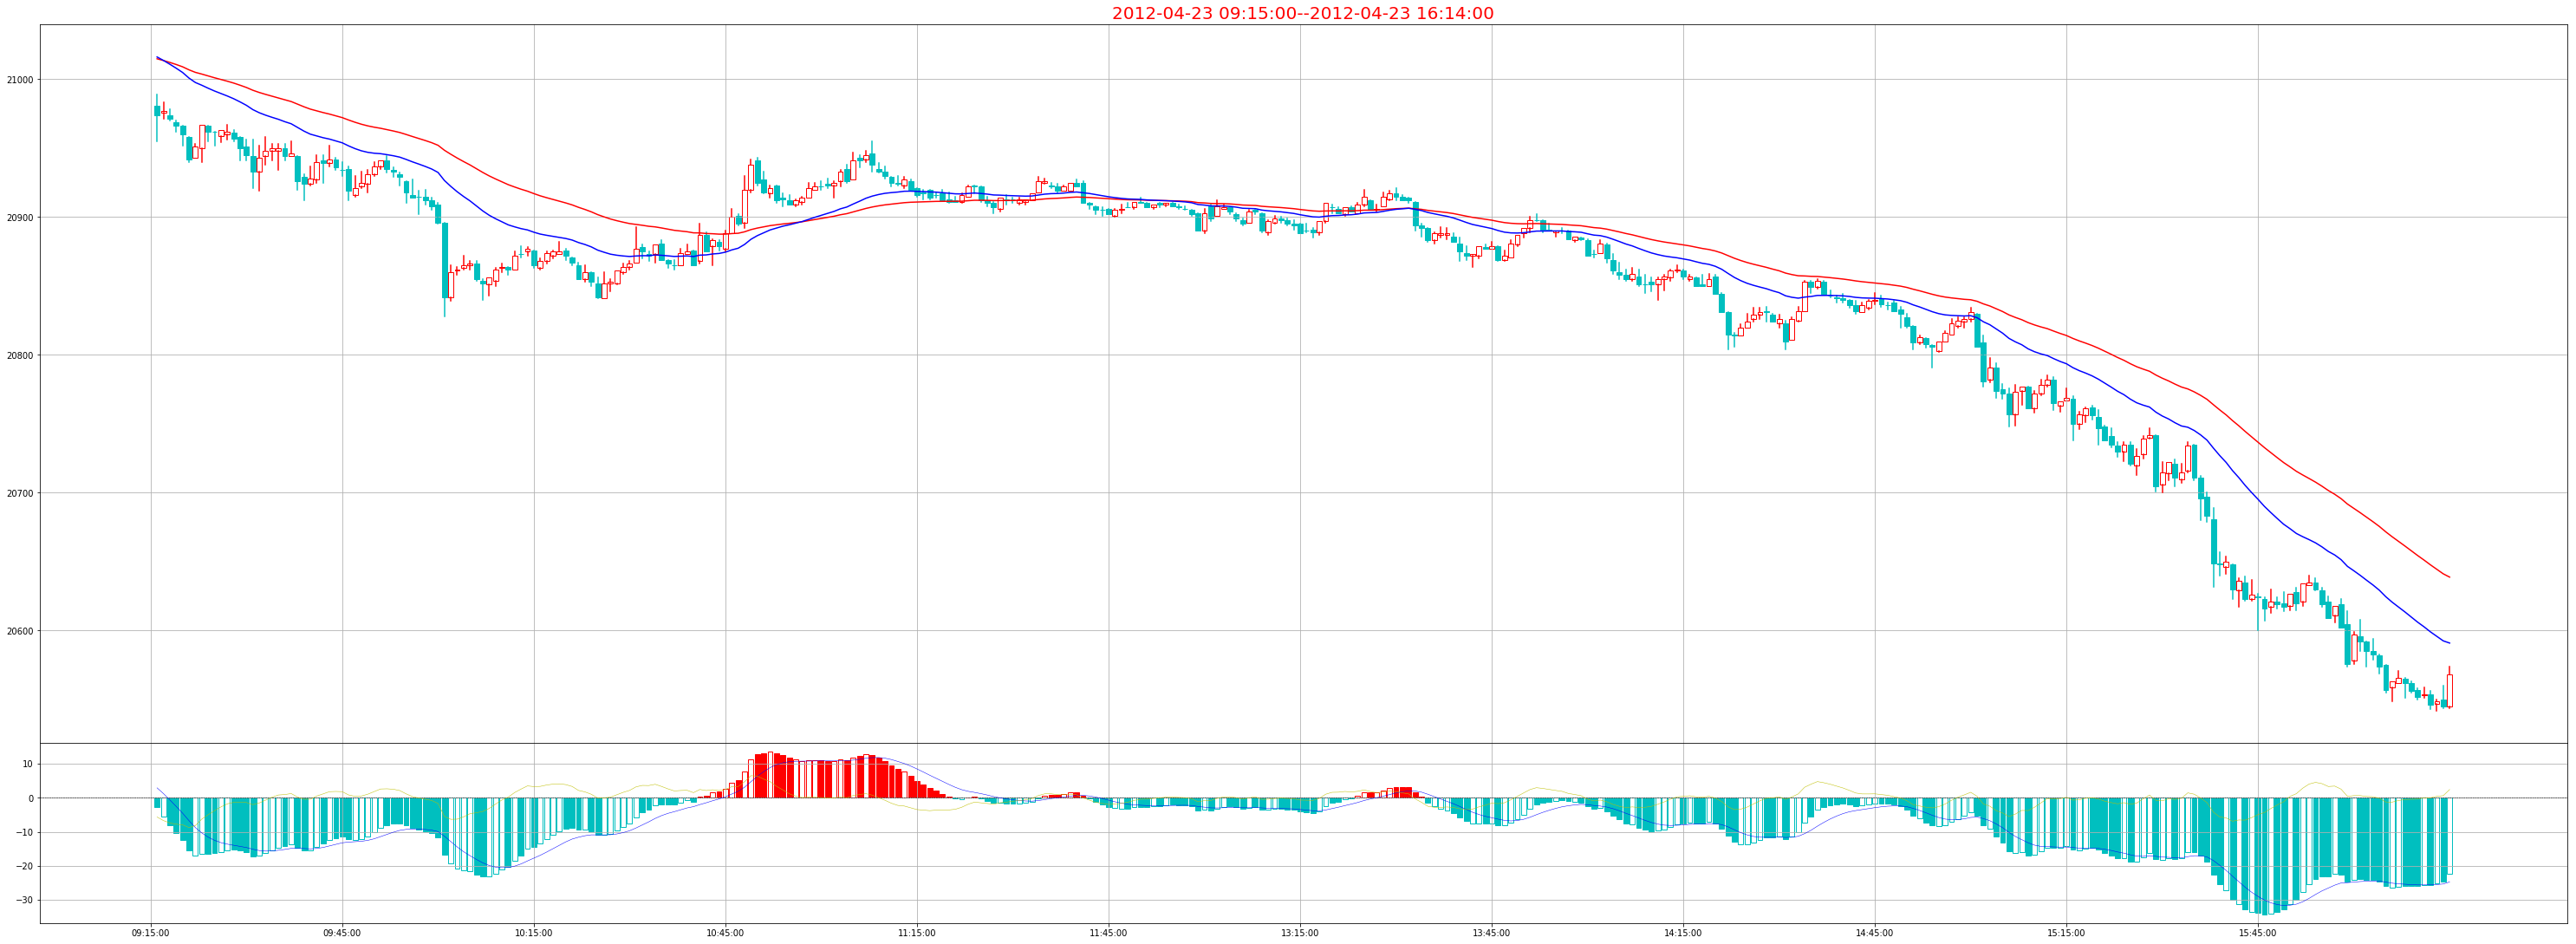

In [78]:
# HSI1511 2015-11-06
KL('HSI1204','2012-04-23')

HSI1812 2018-12-10 img/std_10261_a204.0.jpg
img/std_10261_a204.0.jpg
HSI1802 2018-02-06 img/std_9163_a280.0.jpg
img/std_9163_a280.0.jpg
HSI1604 2016-04-01 img/std_6558_a284.0.jpg
img/std_6558_a284.0.jpg
HSI1204 2012-04-23 img/std_1161_a308.0.jpg


IndexError: single positional indexer is out-of-bounds

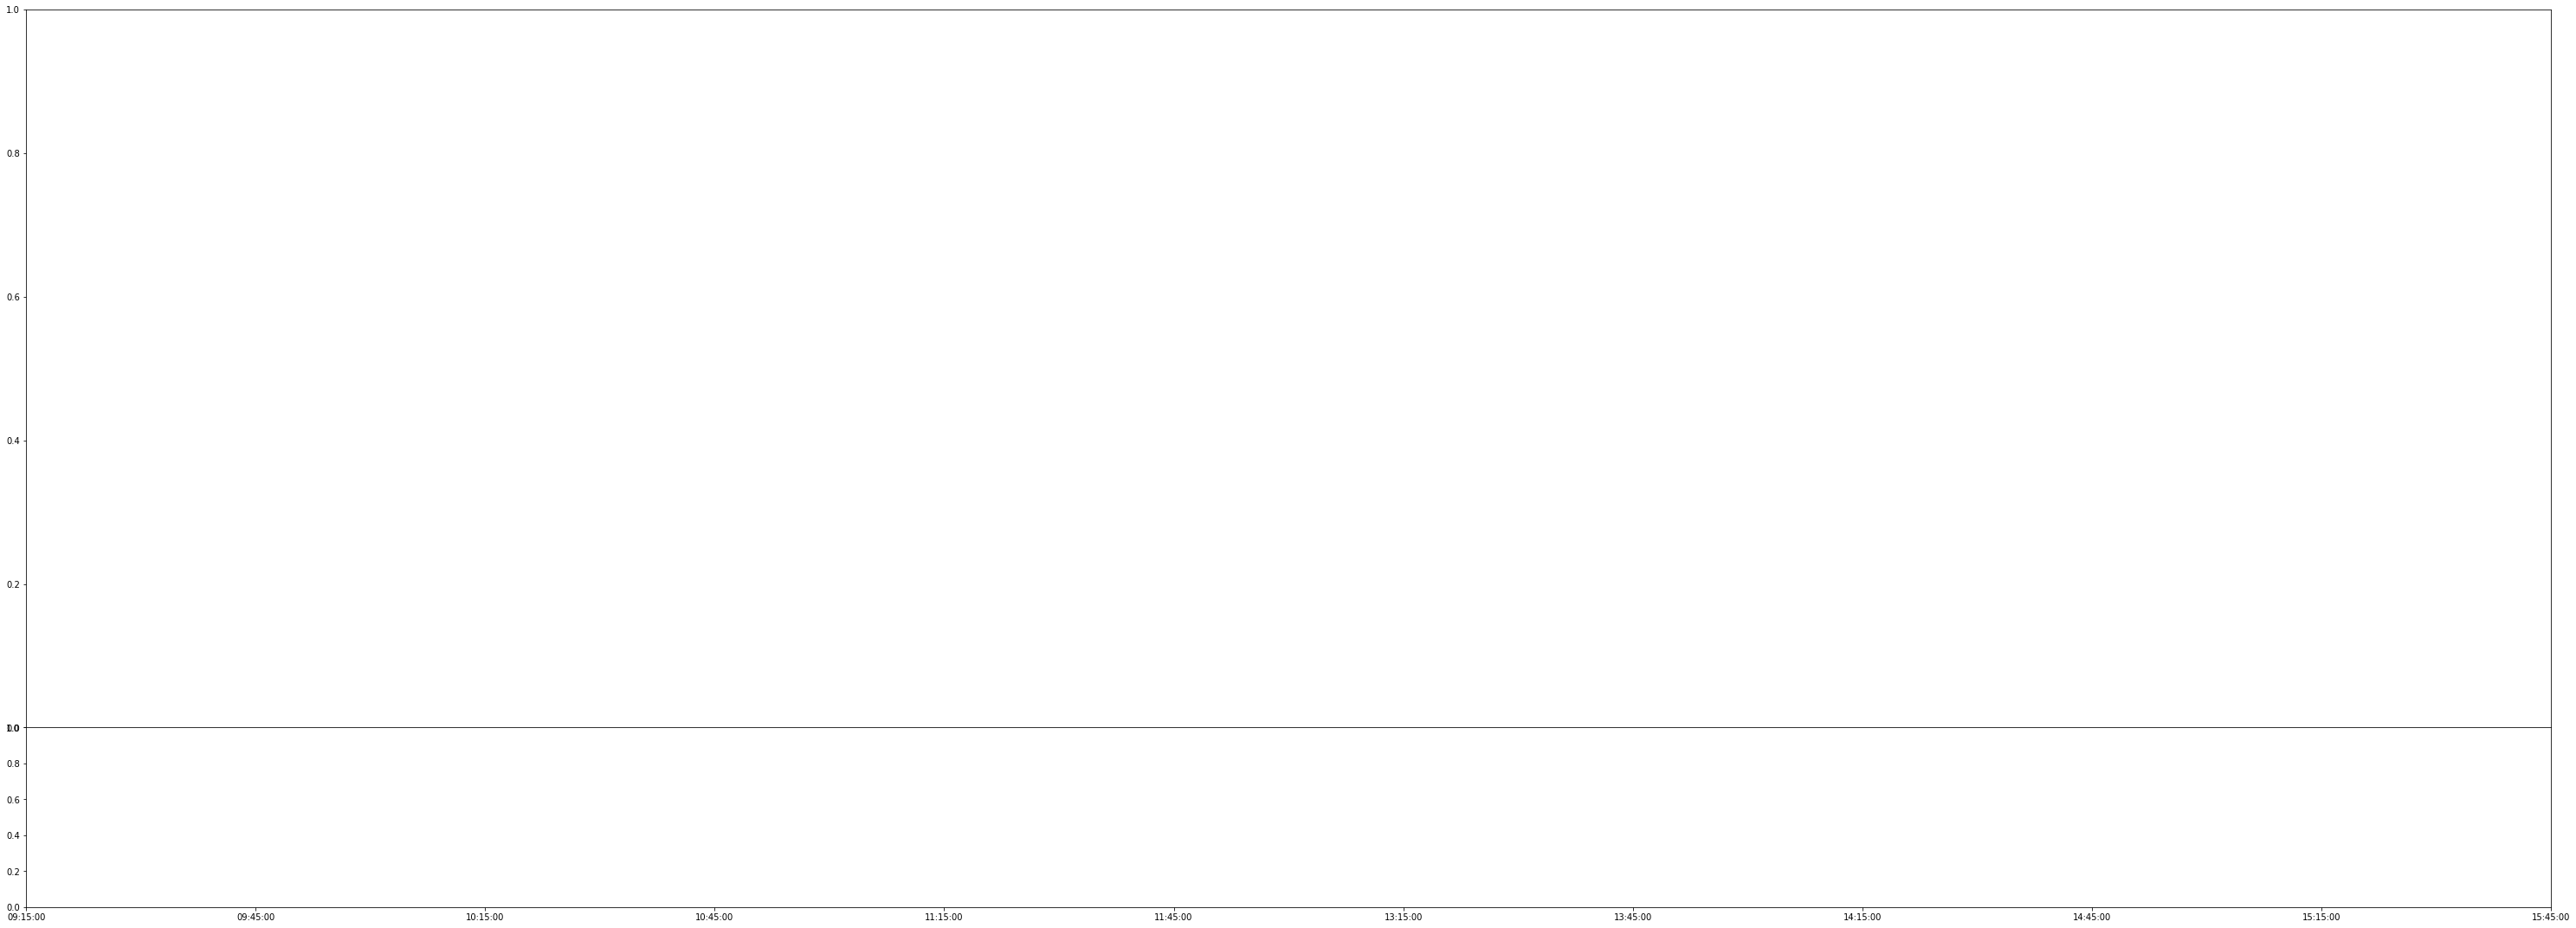

In [77]:
# KL('HSI1901','2019-01-14',buy=[1],save='pkl/std_001.jpg')
cont=(std1.ma60_no==0) & (std1.state==1) & (std1.ma60_state=='under')
std2=std1[cont].sort_values('end_chg',ascending=False)
for i ,row in std2.tail(5).iterrows():
    prod=row['prod']
    date=str(row['date'].date())
    day_no=row['day_no']
    end_idx=row['end_idx']
    chg=row['end_chg']
    if chg>0:
        file="img/std_%d_%s.jpg" %(i,chg)
    else:
        file="img/std_%d_a%s.jpg" %(i,-chg)
    print(prod,date,file)
    if row['state']==1:
        KL(prod,date,trade=['buy',day_no,end_idx],save=file)
    else:
        KL(prod,date,trade=['sell',day_no,end_idx],save=file)